# Gaussian Process

We examine the Gaussian process from both the weight-space and function-space perspectives.
## Weight-space View

### Linear Model:

   $$
   f(x) = x^\top w
   $$

   $$
   y = f(x) + \epsilon
   $$

   - $ x $ is the input vector.
   - $ w $ is the vector of weights (parameters) of the linear model.
   - $ f(x) $ is the function value.
   - $ y $ is the observed target value.
   - $ \epsilon \sim \mathcal{N}(0, \sigma^2_n) $ is the additive noise.

**Likelihood**:

   $$
   p(y|X,w) = \prod_{i=1}^n p(y_i|x_i, w) = \prod_{i=1}^n \frac{1}{\sqrt{2\pi\sigma^2_n}} \exp\left( -\frac{(y_i - x_i^\top w)^2}{2\sigma^2_n} \right)
   $$

   $$
   = \frac{1}{(2\pi\sigma^2_n)^{n/2}} \exp\left( -\frac{1}{2\sigma^2_n} \|y - X^\top w\|^2 \right)
   $$

   - $ y $ is the vector of observed target values.
   - $ X $ is the matrix of input vectors.
   - $ \sigma^2_n $ is the variance of the noise.
   - The likelihood $ p(y|X,w) $ represents the probability of observing $ y $ given $ X $ and $ w $.

**Prior**:
   $$
   w \sim \mathcal{N}(0, \Sigma_p)
   $$
   - A zero-mean Gaussian prior with covariance matrix $ \Sigma_p $ is placed on the weights $ w $.

**Posterior**:

   $$
   p(w|y,X) = \frac{p(y|X,w) p(w)}{p(y|X)}
   $$

   $$
   p(w|X,y) \propto \exp\left( -\frac{1}{2\sigma^2_n} (y - X^\top w)^\top (y - X^\top w) \right) \exp\left( -\frac{1}{2} w^\top \Sigma_p^{-1} w \right)
   $$

   $$
   \propto \exp\left( -\frac{1}{2} \left( w - \bar{w} \right)^\top \left( \frac{1}{\sigma^2_n} XX^\top + \Sigma_p^{-1} \right) \left( w - \bar{w} \right) \right)
   $$
   
   - The posterior distribution $ p(w|X,y) $ is Gaussian with mean $ \bar{w} $ and covariance matrix $ A^{-1} $.
   - $ \bar{w} = \left( \sigma^{-2}_n (XX^\top) + \Sigma_p^{-1} \right)^{-1} Xy $
   - $ A = \sigma^{-2}_n XX^\top + \Sigma_p^{-1} $

**Predictive Distribution**:
   $$
   p(f_*|x_*,X,y) = \int p(f_*|x_*,w) p(w|X,y) \, dw
   $$
   $$
   = \mathcal{N}\left( \frac{1}{\sigma^2_n} x_*^\top A^{-1} Xy, x_*^\top A^{-1} x_* \right)
   $$
   - The predictive distribution for $ f_* = f(x_*) $ at a new input $ x_* $ is obtained by averaging over all possible parameter values, weighted by their posterior probability.

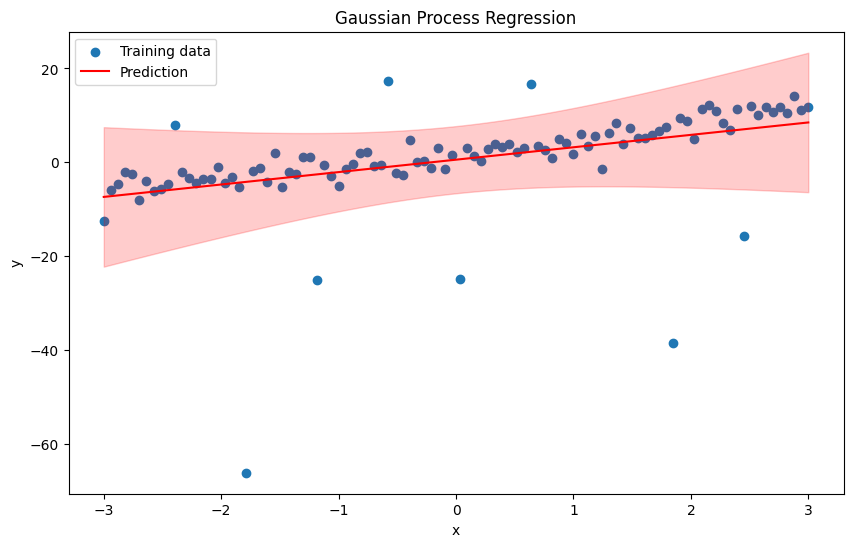

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Generate synthetic data
np.random.seed(0)
x = np.linspace(-3, 3, 100)
y = 2 + 3 * x + 0 * x**2 + np.random.normal(0, 2, x.shape)

# Introduce outliers
y[::10] += 120 * (np.random.rand(10) - 0.5)

# Linear model
def linear_model(X, w):
    return X @ w

# Likelihood (not directly used in the code but provided for completeness)
def likelihood(y, X, w, sigma_n):
    n = len(y)
    pred = linear_model(X, w)
    return (1 / (np.sqrt(2 * np.pi) * sigma_n)) ** n * np.exp(-np.sum((y - pred) ** 2) / (2 * sigma_n ** 2))

# Prior (not directly used in the code but provided for completeness)
def prior(w, Sigma_p):
    d = len(w)
    return (1 / np.sqrt((2 * np.pi) ** d * np.linalg.det(Sigma_p))) * np.exp(-0.5 * w.T @ np.linalg.inv(Sigma_p) @ w)

# Posterior
def posterior(X, y, sigma_n, Sigma_p):
    y = y.reshape(-1, 1)  # Ensure y is a column vector
    A = (1 / sigma_n ** 2) * X.T @ X + np.linalg.inv(Sigma_p)
    w_bar = np.linalg.inv(A) @ (X.T @ y) * (1 / sigma_n ** 2)
    return w_bar, A

# Predictive distribution
def predict(X_train, y_train, X_test, sigma_n, Sigma_p):
    w_bar, A = posterior(X_train, y_train, sigma_n, Sigma_p)
    y_pred = X_test @ w_bar
    pred_var = np.diag(X_test @ np.linalg.inv(A) @ X_test.T)
    return y_pred.flatten(), pred_var

# Add bias term to the input
X_train = np.vstack([np.ones(x.shape), x]).T
y_train = y

# Define test points
x_test = np.linspace(-3, 3, 100)
X_test = np.vstack([np.ones(x_test.shape), x_test]).T

# Hyperparameters
sigma_n = 40
Sigma_p = 80*np.eye(X_train.shape[1])

# Fit and predict using Gaussian Process Regression
y_pred, pred_var = predict(X_train, y_train, X_test, sigma_n, Sigma_p)

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(x, y, label='Training data')
plt.plot(x_test, y_pred, label='Prediction', color='red')
plt.fill_between(x_test, y_pred - 1.96 * np.sqrt(pred_var), y_pred + 1.96 * np.sqrt(pred_var), alpha=0.2, color='red')
plt.title('Gaussian Process Regression')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()


### Step-by-Step Implementation of GP

#### Step 1: Generating Synthetic Data

```python
import numpy as np
import matplotlib.pyplot as plt

# Generate synthetic data
np.random.seed(0)
x = np.linspace(-3, 3, 100)
y = 2 + 3 * x + 0 * x**2 + np.random.normal(0, 2, x.shape)
```

#### Step 2: Define the Linear Model

$$
f(x) = x^\top w
$$

```python
# Linear model
def linear_model(X, w):
    return X @ w
```

#### Step 3: Define the Likelihood

$$
p(y|X,w) = \prod_{i=1}^n p(y_i|x_i, w) = \prod_{i=1}^n \frac{1}{\sqrt{2\pi\sigma^2_n}} \exp\left( -\frac{(y_i - x_i^\top w)^2}{2\sigma^2_n} \right)
$$

```python
def likelihood(y, X, w, sigma_n):
    n = len(y)
    pred = linear_model(X, w)
    return (1 / (np.sqrt(2 * np.pi) * sigma_n)) ** n * np.exp(-np.sum((y - pred) ** 2) / (2 * sigma_n ** 2))
```

#### Step 4: Define the Prior

$$
w \sim \mathcal{N}(0, \Sigma_p)
$$

```python
def prior(w, Sigma_p):
    d = len(w)
    return (1 / np.sqrt((2 * np.pi) ** d * np.linalg.det(Sigma_p))) * np.exp(-0.5 * w.T @ np.linalg.inv(Sigma_p) @ w)
```

#### Step 5: Compute the Posterior

$$
p(w|X,y) \propto \exp\left( -\frac{1}{2\sigma^2_n} (y - X^\top w)^\top (y - X^\top w) \right) \exp\left( -\frac{1}{2} w^\top \Sigma_p^{-1} w \right)
$$

$$
\propto \exp\left( -\frac{1}{2} \left( w - \bar{w} \right)^\top \left( \frac{1}{\sigma^2_n} XX^\top + \Sigma_p^{-1} \right) \left( w - \bar{w} \right) \right)
$$

$$
\bar{w} = \left( \sigma^{-2}_n (XX^\top) + \Sigma_p^{-1} \right)^{-1} Xy
$$

$$
A = \sigma^{-2}_n XX^\top + \Sigma_p^{-1}
$$

```python
def posterior(X, y, sigma_n, Sigma_p):
    A = (1 / sigma_n ** 2) * X.T @ X + np.linalg.inv(Sigma_p)
    w_bar = np.linalg.inv(A) @ (1 / sigma_n ** 2) * X.T @ y
    return w_bar, A
```

#### Step 6: Define the Predictive Distribution

$$
p(f_*|x_*,X,y) = \int p(f_*|x_*,w) p(w|X,y) \, dw
$$

$$
= \mathcal{N}\left( \frac{1}{\sigma^2_n} x_*^\top A^{-1} Xy, x_*^\top A^{-1} x_* \right)
$$

```python
def predict(X_train, y_train, X_test, sigma_n, Sigma_p):
    w_bar, A = posterior(X_train, y_train, sigma_n, Sigma_p)
    y_pred = X_test @ w_bar
    pred_var = np.diag(X_test @ np.linalg.inv(A) @ X_test.T)
    return y_pred, pred_var
```

## Weight-space View : Nonlinear model
As discussed in the Linearization section of the Pattern Recognition course under Regression (Linearization), we use the feature space $\phi$ defined as the Transformed Feature Space: $\phi(x) = [1, x, x^2, \ldots, x^k]$. This technique linearizes the problem, allowing us to continue using a linear model as explained in the above section.

**Remember: Polynomial Linearization: Understanding and Application**

Polynomial regression is a form of linear regression where the relationship between the independent variable $ x $ and the dependent variable $ y $ is modeled as an $ n $-degree polynomial. Despite its non-linear appearance, polynomial regression is treated as a linear regression problem by transforming the feature space.

### Key Concepts

**Polynomial Features**:
   - Polynomial regression extends linear regression by including polynomial terms of the features.
   - For example, in a quadratic polynomial regression, the model can be expressed as:

     $$
     y = \beta_0 + \beta_1 x + \beta_2 x^2 + \epsilon
     $$

   - For a cubic polynomial regression, it becomes:

     $$
     y = \beta_0 + \beta_1 x + \beta_2 x^2 + \beta_3 x^3 + \epsilon
     $$
   - By creating polynomial features, the regression model learns more complex relationships.

**Linearization**:
   - Polynomial regression is a linear model in terms of the coefficients $\beta$.
   - Although the features themselves are non-linear (e.g., $x^2$ or $x^3$), the relationship between the transformed features and the target variable $y$ remains linear.
   

**Feature Transformation**:
   - To handle polynomial regression, we transform the original feature vector $ x $ into a higher-dimensional feature space.
   - For a cubic polynomial, the feature vector $ x $ is transformed as follows:

     $$
     \phi(x) = \begin{bmatrix} x^3 \\ x^2 \\ x \\ 1 \end{bmatrix}
     $$

   - This transformation allows us to apply linear regression methods to the polynomial feature space.

#### Practical Application

**Data Preparation**:
   - Convert the original feature vector $ x $ into the polynomial feature space.
   - For example, for a cubic polynomial, use the transformation:

     ```python
     def polynomial_features(x):
         return np.hstack([x**3, x**2, x, np.ones_like(x)])
     ```

**Regression Model**:
   - The regression model can be applied to these polynomial features just like linear regression.
   - The regression coefficients are estimated based on these transformed features, and predictions are made in the same feature space.

**Example Code**:
   - Here's how you can apply polynomial features and perform linear regression:

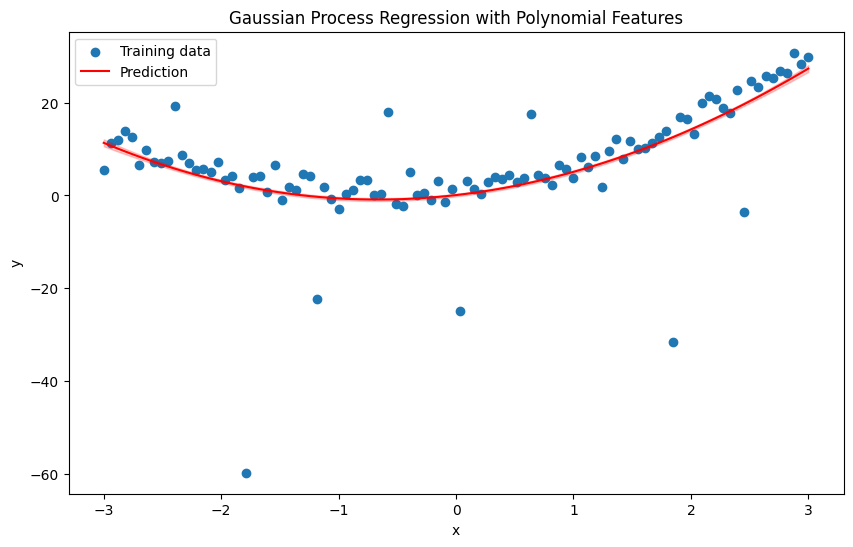

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Generate synthetic data
np.random.seed(0)
x = np.linspace(-3, 3, 100).reshape(-1, 1)  # Ensure x is a column vector
y =  2 + 3 * x + 2 * x**2 + np.random.normal(0, 2, (x.shape[0],1))  # y as a 1D array
#2 * x**2 - 3 * x + 5
# Introduce outliers
n_outliers = 10
outlier_indices = np.arange(0, len(x), len(x) // n_outliers)
y = y.flatten()  # Convert y to 1D
y[outlier_indices] += 120 * (np.random.rand(len(outlier_indices)) - 0.5)

# Polynomial features transformation
def polynomial_features(x):
    return np.hstack([x*x*x, x**2, x, np.ones_like(x)])

# Linear model
def linear_model(X, w):
    return X @ w

# Posterior
def posterior(X, y, sigma_n, Sigma_p):
    y = y.reshape(-1, 1)  # Ensure y is a column vector
    A = (1 / sigma_n ** 2) * (X.T @ X) + np.linalg.inv(Sigma_p)
    w_bar = np.linalg.inv(A) @ (X.T @ y)  # No need to multiply by (1 / sigma_n ** 2) here
    return w_bar, A

# Predictive distribution
def predict(X_train, y_train, X_test, sigma_n, Sigma_p):
    w_bar, A = posterior(X_train, y_train, sigma_n, Sigma_p)
    y_pred = X_test @ w_bar
    # Calculate predictive variance for each test point
    pred_var = np.array([X_test[i, :] @ np.linalg.inv(A) @ X_test[i, :].T for i in range(X_test.shape[0])])
    return y_pred.flatten(), pred_var.flatten()

# Prepare training and test data
X_train = polynomial_features(x)  # Polynomial features for training
X_test = polynomial_features(np.linspace(-3, 3, 100).reshape(-1, 1))  # Same features for test

# Training data
y_train = y

# Hyperparameters
sigma_n = 0.99
Sigma_p = 1*np.eye(X_train.shape[1])

# Fit and predict using Gaussian Process Regression
y_pred, pred_var = predict(X_train, y_train, X_test, sigma_n, Sigma_p)

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(x, y, label='Training data')
plt.plot(np.linspace(-3, 3, 100), y_pred, label='Prediction', color='red')
plt.fill_between(np.linspace(-3, 3, 100), y_pred - 1.96 * np.sqrt(pred_var), y_pred + 1.96 * np.sqrt(pred_var), alpha=0.2, color='red')
plt.title('Gaussian Process Regression with Polynomial Features')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()


## Homework 1
Explore the ***multivariate weight-space*** view for both linear and nonlinear models. Write the necessary mathematical formulations and apply them using appropriate code on suitable data.

## Function-Space View with Gaussian Processes

In the function-space view, we use a Gaussian Process (GP) to describe a distribution over functions. 


### From $\phi $ space (Feature space) to kernel-based covariance

##### Projections of Inputs into Feature Space

**Feature Mapping**:
   - The input vector $ x $ is projected into a feature space using a mapping $ \phi(x) $.
   - For example, a scalar input $ x $ can be mapped into the space of its powers: $\phi(x) = (1, x, x^2, x^3, \ldots)^\top$.

**Predictive Distribution in Feature Space**:
   - The predictive distribution becomes:
     $$
     f_* | x_*, X, y \sim \mathcal{N}\left( \frac{1}{\sigma^2_n} \phi(x_*)^\top A^{-1} \Phi y, \phi(x_*)^\top A^{-1} \phi(x_*) \right)
     $$
   - Here, $\Phi = \Phi(X)$ is the matrix of feature vectors of the training data.
   - $A = \sigma^{-2}_n \Phi \Phi^\top + \Sigma_p^{-1}$.

### Kernel Trick

To address the computational challenge, we use the kernel trick:

**Rewriting the Predictive Distribution**:
   - The predictive distribution can be rewritten using the kernel trick:
     $$
     f_* | x_*, X, y \sim \mathcal{N}\left( \phi_*^\top \Sigma_p \Phi (K + \sigma^2_n I)^{-1} y, \phi_*^\top \Sigma_p \phi_* - \phi_*^\top \Sigma_p \Phi (K + \sigma^2_n I)^{-1} \Phi^\top \Sigma_p \phi_* \right)
     $$
   - Here, $\phi_* = \phi(x_*)$ and $K = \Phi^\top \Sigma_p \Phi$.

### Covariance Function (Kernel)

**Inner Products in Feature Space**:
   - The feature space enters the equations in the form of $\Phi^\top \Sigma_p \Phi$, $\phi_*^\top \Sigma_p \Phi$, or $\phi_*^\top \Sigma_p \phi_*$.
   - These entries are inner products $\phi(x)^\top \Sigma_p \phi(x')$ where $x$ and $x'$ are in the training or test sets.

**Kernel Definition**:
   - Define the kernel function $k(x, x') = \phi(x)^\top \Sigma_p \phi(x')$.
   - This kernel function is also known as a covariance function.

### Function-Space View with Gaussian Processes

In the function-space view, we use a Gaussian Process (GP) to describe a distribution over functions. 
**Mean and Covariance Functions**:
   - The mean function $m(x)$ and the covariance function $k(x,x')$ of a real process $f(x)$ are defined as:

     $$
     m(x) = \mathbb{E}[f(x)]
     $$

     $$
     k(x, x') = \mathbb{E}[(f(x) - m(x))(f(x') - m(x'))]
     $$

   - A Gaussian process can be written as:

     $$
     f(x) \sim \mathcal{GP}(m(x), k(x, x'))
     $$

**Zero Mean Function**:
   - For simplicity, the mean function is often taken to be zero:

     $$
     m(x) = 0
     $$

**Random Variables in GPs**:
   - In this context, the random variables represent the value of the function $f(x)$ at location $x$. The index set $X$ is the set of possible inputs.

**Example: Bayesian Linear Regression**:
   - Consider a Bayesian linear regression model $f(x) = \phi(x)^\top w$ with prior $w \sim \mathcal{N}(0, \Sigma_p)$. For this model:
   
     $$
     \mathbb{E}[f(x)] = \phi(x)^\top \mathbb{E}[w] = 0
     $$
     $$
     \mathbb{E}[f(x) f(x')] = \phi(x)^\top \mathbb{E}[w w^\top] \phi(x') = \phi(x)^\top \Sigma_p \phi(x')
     $$
   - The covariance function specifies the covariance between pairs of random variables:
     $$
     \text{cov}(f(x_p), f(x_q)) = k(x_p, x_q) = \exp\left( -\frac{1}{2} |x_p - x_q|^2 \right)
     $$

#### Incorporate Observational Noise

Assume we have noisy observations $ y_i = f(x_i) + \epsilon_i $ where $\epsilon_i \sim \mathcal{N}(0, \sigma^2)$. The noise variance $\sigma^2$ is added to the diagonal of the covariance matrix:

$$ \mathbf{y} \sim \mathcal{N}(\mathbf{0}, \mathbf{K} + \sigma^2 \mathbf{I}) $$

<h2 style="color:red;"> Joint Distribution of Training and Test Points</h2>

Consider a new test input $ x_* $. The joint distribution of the observed targets $\mathbf{y}$ and the function value $ f_* = f(x_*) $ at $ x_* $ is:

$$
\begin{bmatrix} \mathbf{y} \\ f_* \end{bmatrix} \sim \mathcal{N} \left( \mathbf{0}, \begin{bmatrix} \mathbf{K} + \sigma^2 \mathbf{I} & \mathbf{k}_* \\ \mathbf{k}_*^T & k(x_*, x_*) \end{bmatrix} \right)
$$

where $\mathbf{k}_* = [k(x_1, x_*), k(x_2, x_*), \ldots, k(x_N, x_*)]^T$ is the covariance vector between the training inputs and the test input.

<h2 style="color:blue;"> Conditional Distribution for Predictions</h2>

Or
### Prediction with Gaussian Processes

The predictive distribution $ p(f_* | \mathbf{X}, \mathbf{y}, x_*) $ can be derived using the properties of multivariate Gaussian distributions. The conditional distribution of $ f_* $ given $\mathbf{y}$ is:

$$
f_* | \mathbf{X}, \mathbf{y}, x_* \sim \mathcal{N}(\mu_*, \sigma_*^2)
$$

where the mean and variance are given by:

$$
\mu_* = \mathbf{k}_*^T (\mathbf{K} + \sigma^2 \mathbf{I})^{-1} \mathbf{y}
$$

$$
\sigma_*^2 = k(x_*, x_*) - \mathbf{k}_*^T (\mathbf{K} + \sigma^2 \mathbf{I})^{-1} \mathbf{k}_*
$$

### Do works
The six steps for Gaussian Process regression:

1. **Define the Gaussian Process**: $ f(x) \sim \mathcal{GP}(0, k(x, x')) $
2. **Specify the Kernel Function**: Commonly used kernels include the RBF kernel.
3. **Formulate the Joint Distribution**: $\mathbf{f} \sim \mathcal{N}(\mathbf{0}, \mathbf{K})$
4. **Incorporate Observational Noise**: $\mathbf{y} \sim \mathcal{N}(\mathbf{0}, \mathbf{K} + \sigma^2 \mathbf{I})$
5. **Joint Distribution of Training and Test Points**: $\begin{bmatrix} \mathbf{y} \\ f_* \end{bmatrix} \sim \mathcal{N} \left( \mathbf{0}, \begin{bmatrix} \mathbf{K} + \sigma^2 \mathbf{I} & \mathbf{k}_* \\ \mathbf{k}_*^T & k(x_*, x_*) \end{bmatrix} \right)$
6. **Conditional Distribution for Predictions**:
   - Mean: $ \mu_* = \mathbf{k}_*^T (\mathbf{K} + \sigma^2 \mathbf{I})^{-1} \mathbf{y} $
   - Variance: $ \sigma_*^2 = k(x_*, x_*) - \mathbf{k}_*^T (\mathbf{K} + \sigma^2 \mathbf{I})^{-1} \mathbf{k}_* $

_Function Space view of Gaussian Processes_ offer a **flexible and powerful way and non-parametric method** to model complex, non-linear relationships while providing probabilistic predictions with associated uncertainties.

### Algorithm for GP-based Prediction

1. Input: $X$ (training inputs), $y$ (training targets), $k$ (covariance function), $\sigma_n^2$ (noise level), $x_*$ (test input)
2. Compute the Cholesky decomposition: $L := \text{cholesky}(K + \sigma_n^2 I)$
3. Solve for $\alpha$: $\alpha := L^\top \backslash (L \backslash y)$
4. Compute the predictive mean: $\bar{f}_* := k_*^\top \alpha$
5. Compute the intermediate variable $v$: $v := L \backslash k_*$
6. Compute the predictive variance: $\text{Var}[f_*] := k(x_*, x_*) - v^\top v$

Output: $\bar{f}_*$ (mean), $\text{Var}[f_*]$ (variance)

#### Calculating the Log Marginal Likelihood using $\alpha$ and $L$

The log marginal likelihood of the observed data $y$ given the inputs $X$ under the Gaussian process model is:

$$
\log p(y|X) = -\frac{1}{2} y^\top \alpha - \sum_i \log L_{ii} - \frac{n}{2} \log 2\pi
$$


## Homework 1
What is the relationship between complexity and the term $ \sum_i \log L_{ii} $, and model fit and the term $ y^\top \alpha $?"
Also, change the points (in the following code) for training and testing, and adjust the parameters. Then, explain what occurs.

### Implementation of GP prediction

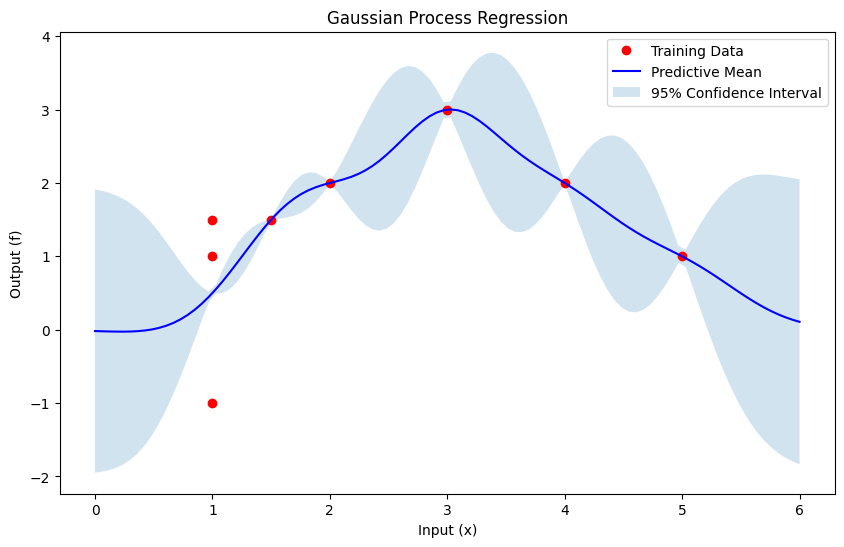

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Define the RBF kernel
def rbf_kernel(X1, X2, length_scale=1.0):
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return np.exp(-0.5 / length_scale**2 * sqdist)

# Training data (inputs and outputs)
X_train = np.array([[1], [2], [3], [4], [5], [1.0],[1.5], [1]])
y_train = np.array([1, 2, 3, 2, 1, 1.5, 1.5, -1])

# Test data (inputs)
X_test = np.linspace(0, 6, 100).reshape(-1, 1)
length_scale=0.5
# Compute the covariance matrices
K = rbf_kernel(X_train, X_train, length_scale)
K_s = rbf_kernel(X_train, X_test, length_scale)
K_ss = rbf_kernel(X_test, X_test, length_scale)
sigma_n = 0.01  # Noise level

# Compute the Cholesky decomposition
L = np.linalg.cholesky(K + sigma_n**2 * np.eye(len(X_train)))

# Solve for alpha
alpha = np.linalg.solve(L.T, np.linalg.solve(L, y_train))

# Predictive mean
mean_s = np.dot(K_s.T, alpha)

# Solve for v
v = np.linalg.solve(L, K_s)

# Predictive variance
var_s = np.diag(K_ss) - np.sum(v**2, axis=0)
std_s = np.sqrt(var_s)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(X_train, y_train, 'ro', label='Training Data')
plt.plot(X_test, mean_s, 'b-', label='Predictive Mean')
plt.fill_between(X_test.ravel(), mean_s - 1.96 * std_s, mean_s + 1.96 * std_s, alpha=0.2, label='95% Confidence Interval')
plt.xlabel('Input (x)')
plt.ylabel('Output (f)')
plt.title('Gaussian Process Regression')
plt.legend()
plt.show()



### **Polynomial Kernel Function**

$$ k(x_i, x_j) = (x_i^\top x_j + c)^d $$

where:
- $x_i$ and $x_j$ are input vectors.
- $c$ is a constant.
- $d$ is the degree of the polynomial.

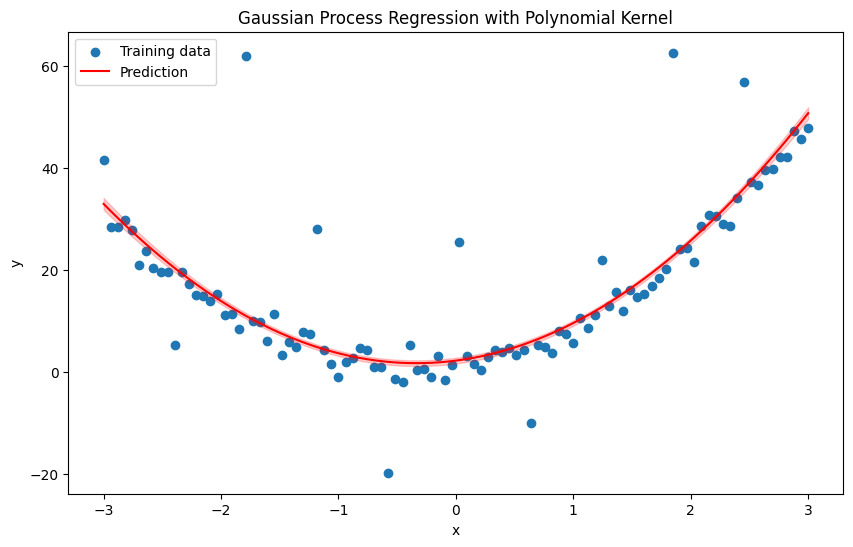

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate synthetic data
np.random.seed(0)
x = np.linspace(-3, 3, 100)
y = 2 + 3 * x + 4 * x**2 + np.random.normal(0, 2, x.shape)

# Remove outliers for simplicity
y[::10] -= 120 * (np.random.rand(10) - 0.5)

# Add bias term to the input
X_train = x.reshape(-1, 1)  # Train input matrix
y_train = y

# Polynomial kernel function
def polynomial_kernel(X1, X2, c=1.0, d=2):
    return (X1 @ X2.T + c) ** d

# Compute the covariance matrices
def compute_covariances(X_train, X_test, sigma_n):
    K_train_train = polynomial_kernel(X_train, X_train)
    K_test_train = polynomial_kernel(X_test, X_train)
    K_test_test = polynomial_kernel(X_test, X_test)
    K_train_train += sigma_n ** 2 * np.eye(X_train.shape[0])  # Add noise variance to the training covariance matrix
    return K_train_train, K_test_train, K_test_test

# Predictive distribution
def predict(X_train, y_train, X_test, sigma_n):
    K_train_train, K_test_train, K_test_test = compute_covariances(X_train, X_test, sigma_n)
    
    # Compute the mean of the predictive distribution
    K_train_train_inv = np.linalg.inv(K_train_train)
    mean = K_test_train @ K_train_train_inv @ y_train
    
    # Compute the covariance of the predictive distribution
    covariance = K_test_test - K_test_train @ K_train_train_inv @ K_test_train.T
    
    return mean.flatten(), np.diag(covariance)

# Define test points
x_test = np.linspace(-3, 3, 100).reshape(-1, 1)
X_test = x_test

# Hyperparameters
sigma_n = 2.0  # Noise variance

# Fit and predict using Gaussian Process Regression
y_pred, pred_var = predict(X_train, y_train, X_test, sigma_n)

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(x, y, label='Training data')
plt.plot(x_test, y_pred, label='Prediction', color='red')
plt.fill_between(x_test.flatten(), y_pred - 1.96 * np.sqrt(pred_var), y_pred + 1.96 * np.sqrt(pred_var), alpha=0.2, color='red')
plt.title('Gaussian Process Regression with Polynomial Kernel')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()


### Again above example with RBF kernel

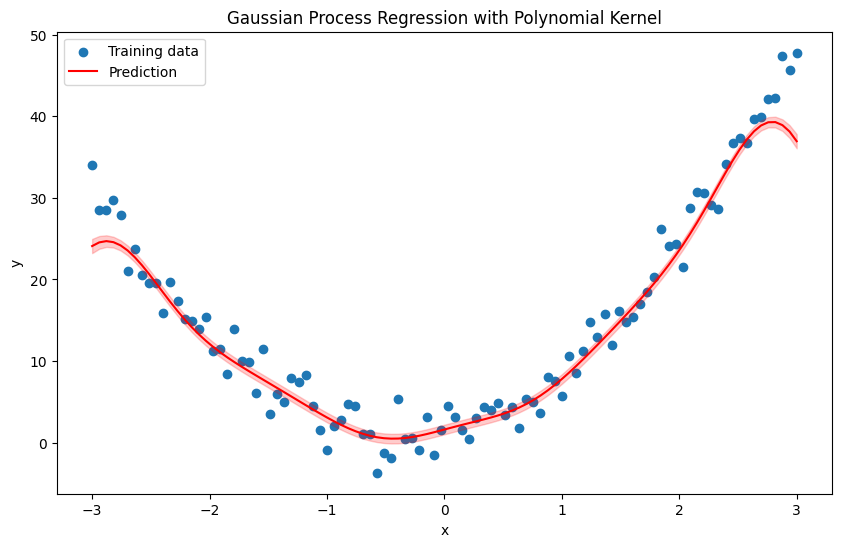

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Generate synthetic data
np.random.seed(0)
x = np.linspace(-3, 3, 100)
y = 2 + 3 * x + 4 * x**2 + np.random.normal(0, 2, x.shape)

# Remove outliers for simplicity
y[::10] -= 20 * (np.random.rand(10) - 0.5)

# Add bias term to the input
X_train = x.reshape(-1, 1)  # Train input matrix
y_train = y

# Define the RBF kernel
def rbf_kernel(X1, X2, length_scale=1.0):
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return np.exp(-0.5 / length_scale**2 * sqdist)

# Compute the covariance matrices
def compute_covariances(X_train, X_test, sigma_n, length_scale):
    K_train_train = rbf_kernel(X_train, X_train, length_scale)
    K_test_train = rbf_kernel(X_test, X_train, length_scale)
    K_test_test = rbf_kernel(X_test, X_test, length_scale)
    K_train_train += sigma_n ** 2 * np.eye(X_train.shape[0])  # Add noise variance to the training covariance matrix
    return K_train_train, K_test_train, K_test_test

# Predictive distribution
def predict(X_train, y_train, X_test, sigma_n, length_scale):
    K_train_train, K_test_train, K_test_test = compute_covariances(X_train, X_test, sigma_n, length_scale)
    
    # Compute the mean of the predictive distribution
    K_train_train_inv = np.linalg.inv(K_train_train)
    mean = K_test_train @ K_train_train_inv @ y_train
    
    # Compute the covariance of the predictive distribution
    covariance = K_test_test - K_test_train @ K_train_train_inv @ K_test_train.T
    
    return mean.flatten(), np.diag(covariance)


# Define test points
x_test = np.linspace(-3, 3, 100).reshape(-1, 1)
X_test = x_test

# Hyperparameters
sigma_n = 1.0  # Noise variance
length_scale=0.5

# Fit and predict using Gaussian Process Regression
y_pred, pred_var = predict(X_train, y_train, X_test, sigma_n, length_scale)

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(x, y, label='Training data')
plt.plot(x_test, y_pred, label='Prediction', color='red')
plt.fill_between(x_test.flatten(), y_pred - 1.96 * np.sqrt(pred_var), y_pred + 1.96 * np.sqrt(pred_var), alpha=0.2, color='red')
plt.title('Gaussian Process Regression with Polynomial Kernel')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()


### RBF with $\epsilon $ Insensitive Loss

C:\Users\Dr\AppData\Local\Temp\ipykernel_8896\3957923635.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  K[i, j] = 4 * loss**2
C:\Users\Dr\AppData\Local\Temp\ipykernel_8896\3957923635.py:76: RuntimeWarning: invalid value encountered in sqrt
  plt.fill_between(x_test.flatten(), y_pred - 1.96 * np.sqrt(pred_var), y_pred + 1.96 * np.sqrt(pred_var), alpha=0.2, color='red')


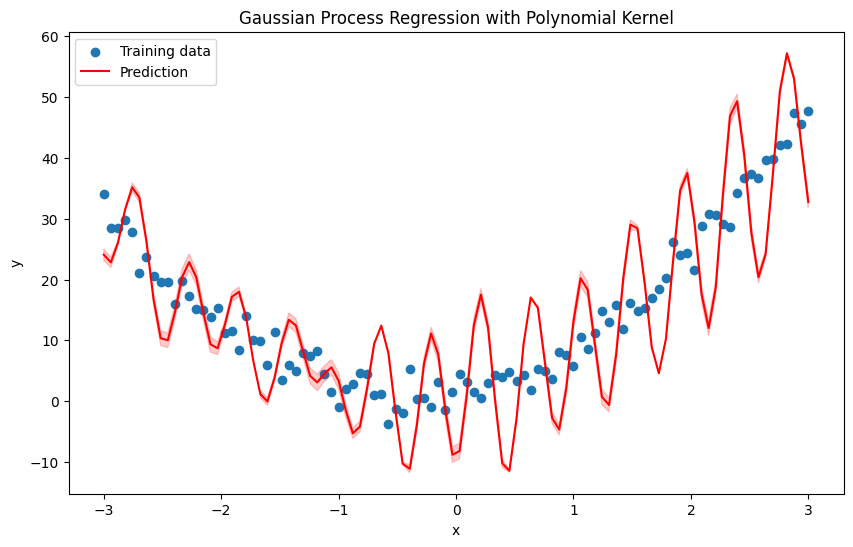

In [41]:
import numpy as np
import matplotlib.pyplot as plt

def epsilon_loss(preds, target, epsilon=0.1):
    n1 = len(preds)
    n2 = len(target)
    K = np.zeros((n1, n2))

    for i in range(n1):
        for j in range(n2):
            errors = np.abs(target[i] - preds[j])
            loss = np.maximum(0, errors - epsilon)
            K[i, j] = 4 * loss**2
    return K

def rbf_kernel(x1, x2, length_scale=1.0, sigma_f=1.0, epsilon=0.1):
    sqdist = epsilon_loss(x1, x2, epsilon)
    return sigma_f**2 * np.exp(-0.5 / length_scale**2 * sqdist)


# # Define the RBF kernel
# def rbf_kernel(X1, X2, length_scale=1.0):
#     sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
#     return np.exp(-0.5 / length_scale**2 * sqdist)

# Compute the covariance matrices
def compute_covariances(X_train, X_test, sigma_n, length_scale, epsilon):
    K_train_train = rbf_kernel(X_train, X_train, length_scale, epsilon)
    K_test_train = rbf_kernel(X_test, X_train, length_scale, epsilon)
    K_test_test = rbf_kernel(X_test, X_test, length_scale, epsilon)
    K_train_train += sigma_n ** 2 * np.eye(X_train.shape[0])  # Add noise variance to the training covariance matrix
    return K_train_train, K_test_train, K_test_test

# Predictive distribution
def predict(X_train, y_train, X_test, sigma_n, length_scale, epsilon):
    K_train_train, K_test_train, K_test_test = compute_covariances(X_train, X_test, sigma_n, length_scale, epsilon)
    
    # Compute the mean of the predictive distribution
    K_train_train_inv = np.linalg.inv(K_train_train)
    mean = K_test_train @ K_train_train_inv @ y_train
    
    # Compute the covariance of the predictive distribution
    covariance = K_test_test - K_test_train @ K_train_train_inv @ K_test_train.T
    
    return mean.flatten(), np.diag(covariance)



# Generate synthetic data
np.random.seed(0)
x = np.linspace(-3, 3, 100)
y = 2 + 3 * x + 4 * x**2 + np.random.normal(0, 2, x.shape)

# Remove outliers for simplicity
y[::10] -= 20 * (np.random.rand(10) - 0.5)

# Add bias term to the input
X_train = x.reshape(-1, 1)  # Train input matrix
y_train = y

# Define test points
x_test = np.linspace(-3, 3, 100).reshape(-1, 1)
X_test = x_test

# Hyperparameters
sigma_n = 1.0  # Noise variance
length_scale=0.5
epsilon= 2
# Fit and predict using Gaussian Process Regression
y_pred, pred_var = predict(X_train, y_train, X_test, sigma_n, length_scale, epsilon)

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(x, y, label='Training data')
plt.plot(x_test, y_pred, label='Prediction', color='red')
plt.fill_between(x_test.flatten(), y_pred - 1.96 * np.sqrt(pred_var), y_pred + 1.96 * np.sqrt(pred_var), alpha=0.2, color='red')
plt.title('Gaussian Process Regression with Polynomial Kernel')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()


## Homework 2
**Preface**

_Discussion on RBF Kernel with $\epsilon$-Insensitive Loss_

In Homework 2, we examined the Radial Basis Function (RBF) kernel and its integration with the $\epsilon$-Insensitive Loss function. This analysis provides insight into how different components of a machine learning model interact, specifically in the context of Gaussian Processes (GPs) and Support Vector Regression.

**Radial Basis Function (RBF) Kernel**:
- The RBF kernel, also known as the Gaussian kernel, is defined as:

  $$
  k(x_i, x_j) = \sigma_f^2 \exp\left(-\frac{\|x_i - x_j\|^2}{2 \ell^2}\right)
  $$

  where $ \sigma_f^2 $ is the signal variance, and $ \ell $ is the length scale parameter.

- **Properties**:
  - **Locality**: The RBF kernel measures similarity based on the distance between points, with closer points being more similar.
  - **Smoothness**: Functions modeled with the RBF kernel are smooth and infinitely differentiable.

**Application in GPs**:
- In Gaussian Processes, the RBF kernel is used to define the covariance function between pairs of data points. It determines how the model smooths and interpolates data.

**$\epsilon$-Insensitive Loss**:

- This loss function is commonly used in Support Vector Regression (SVR) and is defined as:

  $$
  L_\epsilon(y, f(x)) = \begin{cases} 
  0 & \text{if } |y - f(x)| \leq \epsilon \\
  |y - f(x)| - \epsilon & \text{otherwise}
  \end{cases}
  $$

  where $ \epsilon $ is a parameter that specifies a tolerance zone around the prediction $ f(x) $.

**Application in SVR**:
- **Fit Term**: The $\epsilon$-Insensitive Loss function ensures that predictions within an $\epsilon$ margin around the observed data $ y $ incur no loss. This helps in focusing the learning on the points where the prediction deviates significantly from the true value.
- **Robustness**: By ignoring errors within the $\epsilon$ margin, the model becomes less sensitive to outliers and noise in the data.

<h2 style="color:red;">Now You Complete</h2>

**Integration of RBF Kernel and $\epsilon$-Insensitive Loss** 
- Multivariate form 
- Mathematical formulation & experiments
- Mastery over the regulation of $\epsilon$ in the synthetic example above
- Applied to suitable applications that need the $\epsilon$-insensitive property

